<a href="https://colab.research.google.com/github/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/Chapter3_Going_Beyond_the_Basics_Detecting_Features_in_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3: Going Beyond the Basics: Detecting Features in Images
Hi, chào mọi người. Như trên tựa đề đã ghi, ở chương này, tụi mình sẽ đi xa hơn nữa, hơn cả mức cơ bản. Tìm hiểu sâu hơn với khác niệm mới trong mạng thần kinh.

<img src="https://gregorygundersen.com/image/cnns/41847277995.png" alt="Description" style="width:30%;">

Chương này khá dài nên mình sẽ tổng quan trước những cái mới mà chúng mình sẽ học nha:

1. Cách sử dụng **phương pháp tích chập** để trích xuất các **đặc trưng** trong ảnh. Thông qua đó ta hiểu được cách sử dụng các **lớp tích chập (Convolution layer)** để tăng hiệu quả học các bức ảnh. Thêm đó là phần **lớp gộp(Pooling layer)** giúp giảm thiểu số lượng tính toán, tuy nhiên vẫn giữ được các đặc trưng chính.
2. Phương pháp **gia tăng thêm dữ liệu (augmentation)** giúp làm giàu kho dữ liệu hơn, tăng dữ liệu trong quá trình huấn luyện giúp cải thiện mô hình.
3. Phương pháp **học chuyển giao (transfer learning)** giúp mô hình có thể tận dụng lại những kiến thức đã học được trước đó.
4. Ngoài ra chúng mình cũng sẽ tìm hiểu sơ qua về phương pháp **loại bỏ ngẫu nhiên (dropout)** giúp cải thiện mô hình, tránh được tình trạng **quá khớp (overfitting)**.

*Lưu ý: Khuyến khích mọi người sử dụng Colab hãy chuyển sang T4 GPU ở chương này nha vì việc huấn luyện mô hình sử dụng các lớp tích chập tốn khá nhiều thời gian tính toán.*

#1. a) Chúng mình cùng tìm hiểu về phương pháp **"tích chập"** nha

Trước khi vào bài mới chúng mình cùng nhớ lại chút kiến thức ở chương trước ha.

Ở chương 2 lần trước, tụi mình có cùng tìm hiểu về xây dựng một mô hình cơ bản để nhận diện đồ vật thông qua hình ảnh từ bộ dữ liệu fashion_mnist ha. Mô hình lần trước chỉ bao gồm các lớp tuyến tính cơ bản thôi, tụi mình tiến hành trải phẳng một bức ảnh từ 2D sang 1D tức là một mảng hay vector rồi đưa vào các lớp tuyến tính để học.

Kết quả thu được từ mô hình ở chương 2 khá là tốt rồi ha, trên 80%. Tuy nhiên chúng ta có thể thấy được phương pháp này có rất nhiều hạn chế từ việc phải trải phẳng hình ảnh ra, ở dữ liệu fashion_mnist thì chỉ đơn giản là ảnh trắng đen, tức một màu mà khi trải ra số lượng giá trị tuy cũng lớn nhưng mà kiến thức thu được chỉ ở dạng tổng quan hình ảnh mà chúng ta nhìn thấy. Nếu với ảnh màu tức 3 kênh màu (đỏ, xanh, lam) thì việc này sẽ khó khăn đến thế nào để có thể phân biệt được khi chúng ta chỉ nhìn từ một hướng.

> *Liệu có một phương pháp nào đó để ta có thể phân tích sâu hơn các bức ảnh không? Như kiểu chia bức ảnh ra thành các đối tượng nhỏ hơn để có thể phân tích sâu hơn các khía cạnh.*

Câu trả lời là có. Chính là phương pháp tích chập mà ta tìm hiểu này.


Đi sâu vào toán quá thì sẽ khó hiểu nên mọi người cứ nghĩ đơn giản vậy nha:
> Phương pháp **tích chập** trong học máy là thông qua việc sử dụng các bộ lọc để nhìn hình ảnh dưới nhiều góc độ màu sắc hơn, từ đó học được nhiều hơn.

Hmmm, vẫn khó hiểu nhỉ, để mình lấy một ví dụ cụ thể.

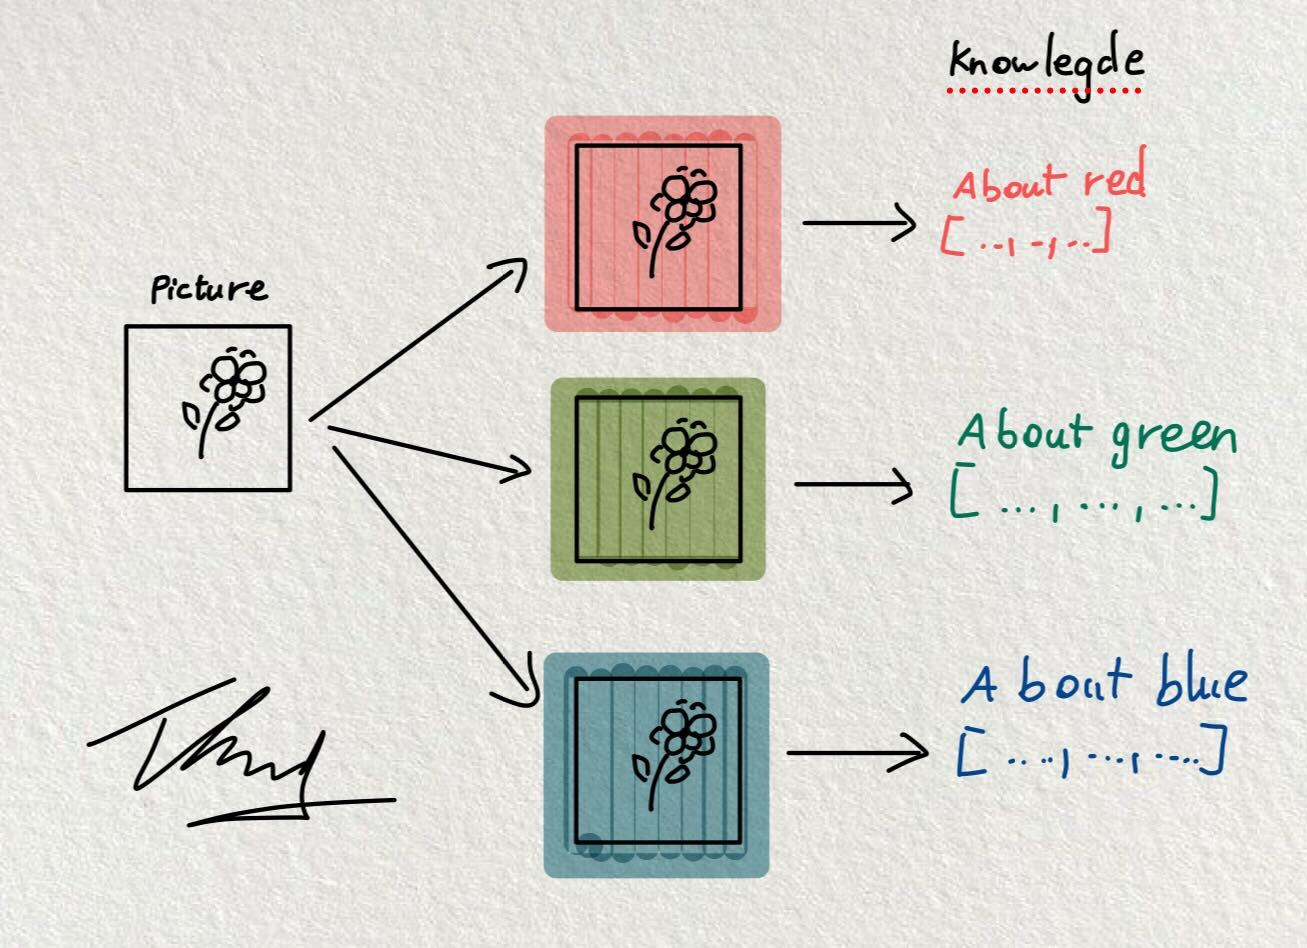

Ở đây mình có một bức ảnh và 3 miếng giấy bóng kính với 3 màu đỏ, xanh, lam. Thì khi mình chồng chúng lên bức ảnh để nhìn thi mình sẽ thấy được bức hình với các màu sắc khác nhau hơn từ đó thu được nhiều dữ liệu hơn.

> Ta có thể nói giấy bóng kính chính là các **bộ lọc** của **lớp tích chập**.

## Mình sẽ đi vào ví dụ về hình ảnh sau khi qua một lớp tích chập ha.

In [1]:
# Tải bộ dữ liệu mnist
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
(train_imgs, train_labels), (test_imgs, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D
import numpy as np
import random

# Chọn ảnh mặc định
img = train_imgs[0]
print("Kích thước ảnh mặc định: ", img.shape)

# Chuẩn hóa ảnh
img = img / 255.0

# Chuyển về dạng array để đưa vào lớp cho dễ
img_arr = np.array(img)

# Ở đây chúng ta sẽ thực hiện một bước nhỏ để chỉ định lại kích thước ảnh,
# thêm số để chỉ định số lượng kênh màu, với ảnh trắng đen thì là 1
img_reshape = img.reshape(1, 28, 28, 1) # số 1 đầu tiên là số mẫu, số 1 ở cuối là số kênh màu

print("Kích thước ảnh sau khi được chuẩn hóa: ", img_reshape.shape)

Kích thước ảnh mặc định:  (28, 28)
Kích thước ảnh sau khi được chuẩn hóa:  (1, 28, 28, 1)


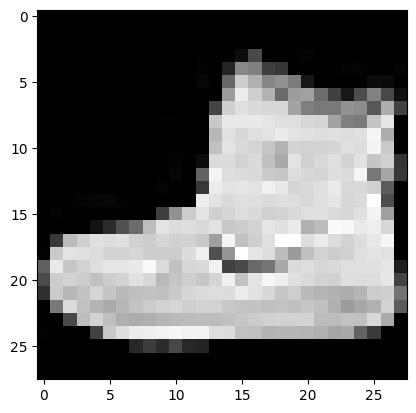

In [3]:
# Xem ảnh mặc định
plt.imshow(img, cmap="gray")

In [4]:
# Khởi tạo lớp convolution
conv_layer = tf.keras.layers.Conv2D(
    filters=8,            # Sử dụng 8 bộ lọc
    kernel_size=(3, 3)   # Kernel kích thước 3x3
)

# Xây dựng lớp Conv2D
conv_layer.build(img_reshape.shape)

In [5]:
# Đưa ảnh qua lớp Convolution
output_images = conv_layer(img_reshape)

# Chuyển đổi đầu ra về dạng numpy
output_images_np = output_images.numpy().squeeze()  # Loại bỏ batch dimension

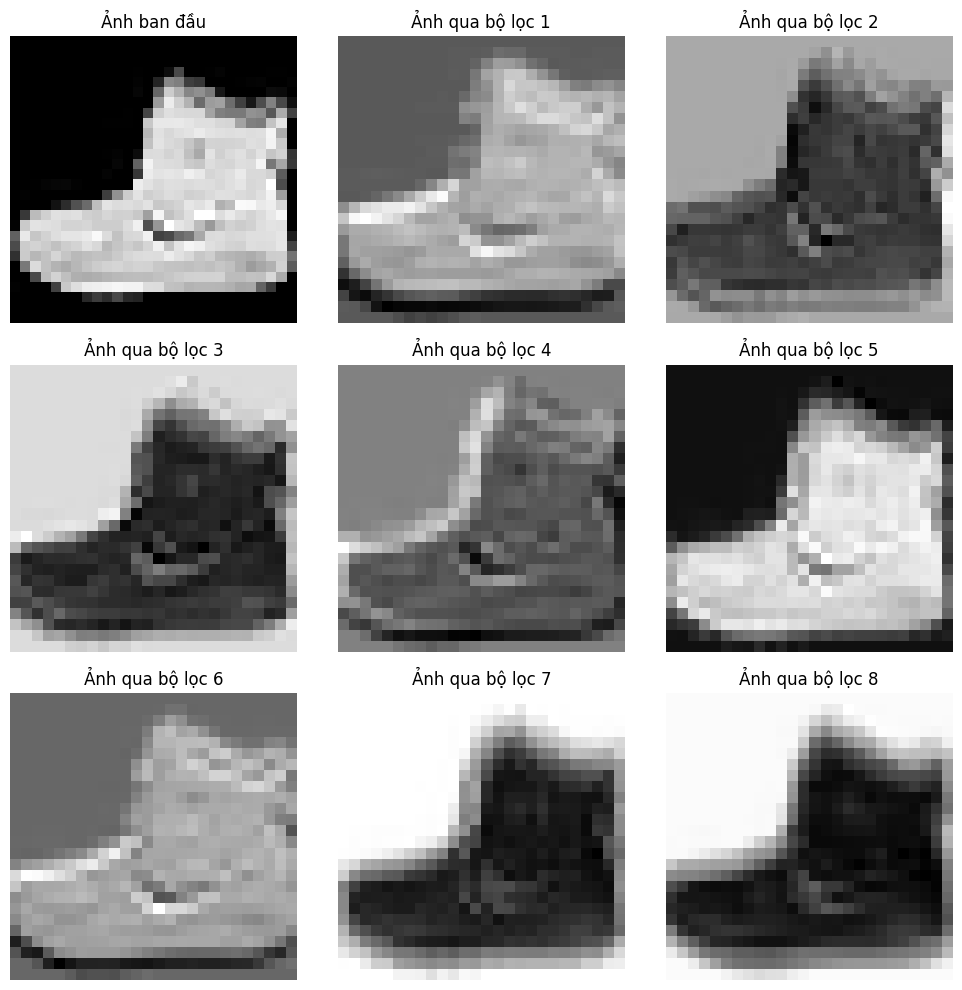

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axs = axs.flatten()

# Hiển thị ảnh gốc
axs[0].imshow(img, cmap="gray")
axs[0].axis("off")
axs[0].set_title("Ảnh ban đầu")

# Hiển thị ảnh đã qua lớp tích chập
for i in range(8):
    axs[i+1].imshow(output_images_np[..., i], cmap="gray")
    axs[i+1].axis("off")
    axs[i+1].set_title(f"Ảnh qua bộ lọc {i+1}")

plt.tight_layout()
plt.show()

In [7]:
print("Kích thước ảnh sau khi qua lớp tích chập: ", output_images_np[..., i].shape)

Kích thước ảnh sau khi qua lớp tích chập:  (26, 26)


Như mọi người thấy, bức ảnh sau khi qua lớp tích chập có 8 bộ lọc, sinh ra 8 bức ảnh khác nhau, từ đó mô hình có thể học được nhiều khía cạnh, đặc trưng khác nhau của hình ảnh ban đầu.

Mọi người tinh mắt có thể nhận thấy, kích thước đầu vào của ảnh là (28 x 28) nhưng sau khi qua lớp tích chập thì kích thước chỉ còn (26 x 26). Điều này diễn ra là vì khi trải qua bộ lọc (3 x 3) thì phần viền hình ảnh sẽ thụt lùi vô để gộp với nhân của bộ lọc. Nói vậy khá khó hỉu nên mình sẽ lấy một hình ảnh làm ví dụ.

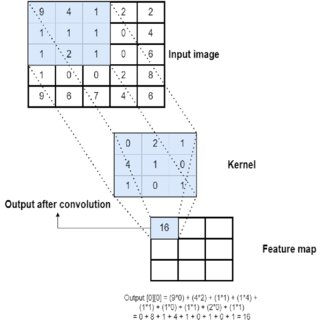

Sau khi phần **cửa sổ (3 x 3)** trượt trên hình ảnh gốc và cắt một phần ra nhân với **bộ lọc (kernel 3 x 3)** thì chúng tổng hợp lại còn 1 ô là 16 tương ứng với vị trí trung tâm số 1 ở giữa của cửa sổ và bộ lọc. Do đó phần viền ảnh trái, phải, trên, dưới đều bị cắt đi. Một ảnh có kích thước **A x B** sau khi qua lớp tích chập cơ bản thông thường thì kích thước đầu ra sẽ là **(A-2) x (B-2)**.

> Vậy có cách nào đảm bảo ảnh khi qua lớp tích chập có thể giữ nguyên kích thước không?

Tất nhiên là có rồi. Bạn chỉ cần thêm padding vào ảnh. Bạn hiểu đơn giản phần đệm hay padding là số ô mà mình thêm vào phần viền xung quanh ảnh ha. Như hình bên dưới thì là 1.

![Image about padding.gift Nếu các bạn không thấy ảnh gift thì chắc medium bị chặn, các bạn có thể bật 1.1.1.1 lên nha](https://miro.medium.com/v2/resize:fit:640/format:webp/1*1okwhewf5KCtIPaFib4XaA.gif)

Phần màu xanh lam đại diện cho **ảnh gốc** kích thước 5 x 5.

Phần xám quét qua là **cửa sổ trượt** với kích thước 3 x 3. (Chú thích: cửa sổ trượt là phần sẽ quét qua tấm ảnh và nhân các giá trị trong đó với bộ lọc). Như trên hình thì người vẽ đã bỏ qua phần vẽ bộ lọc hoặc mọi người có thể tự hiểu phần xám đó là nơi **áp bộ lọc(kernel)** lên.

Phần xanh lá chính là **ảnh đầu ra** sau khi đã qua bộ lọc.

Khi bộ lọc hay cửa sổ trượt quét qua ảnh đã được thêm padding, thì ô pixel trung tâm bộ lọc có thể nhìn thấy được viền của ảnh gốc, từ đó thu lại được phần viền của ảnh giúp ảnh đầu ra có kích thước tương đương với ảnh gốc.

Công thức thêm padding để giữ lại kích thước ảnh ban đầu là:
> padding = (kernel_size - 1) / 2

với kernel_size là kích thước bộ lọc.

*Lưu ý: kích thước của bộ lọc nên luôn là số lẻ, việc này giúp dễ hơn cho việc tính toán và truy xuất*

---------------------------------------------------------------------------
Ngoài ra lớp tích chập còn có thêm một tham số quan trọng nữa là **bước nhảy(stride)**. Bạn chỉ cần hiểu đơn giản bước nhảy chính là **số ô mà cửa sổ trượt hay bộ lọc(kernel) nhích qua mỗi lần di chuyển**, như ở trên thì là **1**.

Vậy ứng dụng của tham số này là gì, không phải lúc nào việc đi chậm vậy hay bước nhảy là 1(mặc định) cũng tối ưu. Với các bức ảnh lớn thì số lượng tính toán rất lớn, đôi khi việc di chuyển vậy làm **tốn nhiều thời gian**, chưa kể việc nhìn quá chi tiết một bức ảnh đổi khi sẽ **không học được khái quát** hết được hoặc **trở nên quá khớp**.

Lúc này ta có thể tăng số lượng bước nhảy lên, ví dụ như 2 hoặc lớn hơn sẽ giúp bộ lọc di chuyển nhanh hơn, từ đó giảm kích thước đầu ra xuống. Nó giống như việc bạn đi cầu thang vậy, bình thường bạn bước 1 nấc thì mất 16 bước nhưng khi bước cùng lúc 2 nấc thì chỉ còn 8 bước. Qua đó giảm thiểu được lượng lớn thời gian và phép toán cần xử lý. Kích thước ảnh với bước nhảy là 2 sẽ bị giảm đi một nửa.

### Tổng kết lại những tham số bạn cần phải nhớ trong lớp tích chập:
- Kích thước bộ lọc (kernel size).
- Tham số về phần đệm(padding).
- Tham số về bước nhảy(stride).

### Các chỉ số có thể bạn sẽ muốn tìm hiểu thêm.
- Độ giãn nở (dilation rate).

#1. b) Tiếp đến mình tìm hiểu về lớp gộp (pooling layer) ha.
Về ý tưởng lớp gộp không khác gì một lớp tích chập cả, chúng cũng có một bộ lọc quét qua để tổng hợp giá trị lại, cũng có kích thước bộ lọc. Tuy nhiên cách thức tổng hợp sẽ khác. Nếu như ở lớp tích chập, bạn phải nhân bộ lọc với phần được quét từ cửa trượt trên bức ảnh, thì ở đây **lớp gộp (pooling layer)** sử dụng các phép toán đơn giản như tìm giá trị lớn nhất hay tính trung bình giá trị các ô.

Đây là điểm khác chính của **lớp gộp(pooling layer)** ha, chính vì điều đó mà chúng không được coi là một lớp không có khả năng học bởi mục tiêu của chúng là tổng hợp giá trị, đến phần tham số các lớp bạn sẽ thấy rõ hơn, khi mà **lớp tích chập(convolution layer)** lại được xét là có tham số học nhờ việc sinh ra và học các đặc trưng từ ảnh.

Ngoài ra có một vài điểm khác biệt nhỏ, **bước nhảy (stride)** của lớp gộp sẽ chính bằng kích thước cửa sổ quét của chúng.

Ta có **2 phương pháp gộp (pooling)** thường xuất hiện là:

- Gộp theo giá trị lớn nhất (Max pooling).
- Gộp theo trung bình cộng các giá trị (Average pooling).

Để mọi người dễ hiểu hơn mình sẽ thêm 2 ví dụ bên dưới.

Gộp theo giá trị lớn nhất **(Max pooling)**.

![Max pooling](https://miro.medium.com/v2/resize:fit:1400/1*vOxthD0FpBR6fJcpPxq6Hg.gif)

Như các bạn thấy thì phần cửa sổ trượt hay bộ lọc màu đỏ đã quét qua và lấy ra giá trị lớn nhất trong nhóm đó. Từ đó kích thước của tấm ảnh từ 4 x 4 đã giảm xuống còn 2 x 2 với trường hợp không thêm padding vào.

Bây giờ chúng ta đến với lớp gộp trung bình cộng **(Average pooling)**.
![Average pooling](https://raw.githubusercontent.com/valoxe/image-storage-1/master/blog-deep-learning/cnnumpy-naive/5-a.gif)

Cách thức cũng không khác gì lớp gộp ở trên tuy nhiên thay vì tìm giá trị lớn nhất thì lại là tìm giá trị trung bình trong nhóm giá trị.

## Chúng mình sẽ đi vào quan sát rõ hơn hình ảnh sau khi qua lớp này.

In [8]:
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D

# Khởi tạo lớp gộp giá trị lớn nhất (Max pooling)
max_pool = MaxPooling2D(pool_size=(2, 2))
max_pool.build(img_reshape.shape)

# Cho ảnh qua lớp max pooling
img_max_pool = max_pool(img_reshape)
print("Kích thước ảnh sau khi qua lớp gộp giá trị lớn nhất: ",img_max_pool.shape)

# Khưởi tạo lớp gộp trung bình cộng (Average pooling)
avg_pool = AveragePooling2D(pool_size=(2, 2))
avg_pool.build(img_reshape.shape)

# Cho ảnh qua lớp gộp trung bình cộng
img_avg_pool = avg_pool(img_reshape)
print("Kích thước ảnh sau khi qua lớp gộp trung bình cộng: ",img_avg_pool.shape)

Kích thước ảnh sau khi qua lớp gộp giá trị lớn nhất:  (1, 14, 14, 1)
Kích thước ảnh sau khi qua lớp gộp trung bình cộng:  (1, 14, 14, 1)


Như mọi người thấy thì phần kích thước hình ảnh đã bị giảm đi một nửa (từ 28 chỉ còn 14). Bây giờ mình sẽ tiến hành hiển thị hình ảnh sau khi qua 2 lớp lên để quan sát ha.

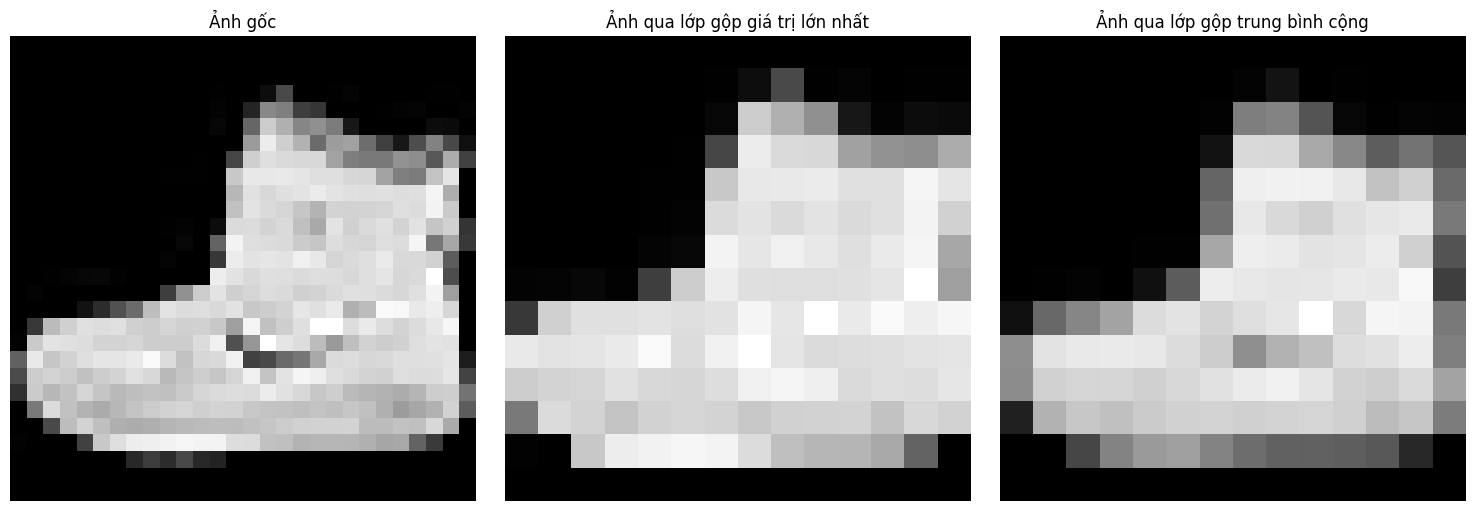

In [9]:
# Chuyển đổi đầu ra về dạng numpy
# output_images_np = output_images.numpy().squeeze()  # Loại bỏ batch dimension
img_max_pool = img_max_pool.numpy().squeeze()
img_avg_pool = img_avg_pool.numpy().squeeze()

# Hiển thị hình ảnh
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()

# Ảnh gốc
axs[0].imshow(img_reshape.squeeze(), cmap='gray')
axs[0].set_title('Ảnh gốc')
axs[0].axis('off')

# Ảnh qua lớp gộp giá trị lớn nhất (max pooling)
axs[1].imshow(img_max_pool, cmap='gray')
axs[1].set_title('Ảnh qua lớp gộp giá trị lớn nhất')
axs[1].axis('off')

# Ảnh qua lớp gộp trung bình cộng (average pooling
axs[2].imshow(img_avg_pool, cmap='gray')
axs[2].set_title('Ảnh qua lớp gộp trung bình cộng')
axs[2].axis('off')

plt.tight_layout()
plt.show()

Như mọi người thấy thì số chi tiết trên hình ảnh sau khi qua lớp gộp đã bị giảm đi khá nhiều do việc gộp lại các ô làm giảm kích thước. Với mỗi phương pháp gộp sẽ cho ra kết quả khác nhau, do đó mọi người có thể linh hoạt sử dụng trong từng trường hợp để so sánh, đưa ra kết quả và lựa chọn tốt nhất với các bài toán.

## Tổng kết lại về lớp gộp (pooling layer):
- Không phải là một lớp có khả năng học.
- Mục tiêu là tổng hợp lại các giá trị giúp giảm số lượng tính toán nhưng lại không đánh mất đi các giá trị quan trọng.
- Các lớp gộp phổ biến: max pooling, average pooling

Ngoài ra mọi người cũng có thể tìm hiểu thêm các phương pháp gộp khác như min pooling, global pooling, mixed pooling, ...

# 1. c) Chúng mình cùng bắt tay vào việc xây dựng cũng như phân tích một mô hình sử dụng các lớp tích chập (convolution) ha.
Ở đây mình vẫn sẽ sử dụng bài toán phân loại đồ đạc dựa trên bộ dữ liệu **fashion mnist** nha.

In [10]:
# Kiểm tra kích thước tập dữ liệu huấn luyện (train) và tập dữ liệu kiểm tra (test)
print("Kích thước tập dữ liệu huấn luyện (train): ",train_imgs.shape)
print("Kích thước tập dữ liệu kiểm tra (test): ",test_imgs.shape)

Kích thước tập dữ liệu huấn luyện (train):  (60000, 28, 28)
Kích thước tập dữ liệu kiểm tra (test):  (10000, 28, 28)


Ở đây ta thấy được rằng tập huấn luyện có tổng cộng 60000 ảnh với kích thước ảnh là 28 x 28. Tập kiểm tra có 10000 ảnh với kích thước ảnh tương tự. Bây giờ chúng ta sẽ tiến hành định dạng lại kích thước các tập.

In [11]:
# Vì bộ dữ liệu của chúng ta hiện tại chỉ đơn giản có kích thước là (số lượng mẫu x chiều cao x chiều rộng)
# Chúng chưa có kích thước về số kênh màu của ảnh nên chúng ta cần định dạng lại.
# Với ảnh trắng đen thì số kênh màu là 1 còn ảnh màu RGB thì sẽ là 3.
train_imgs = train_imgs.reshape(60000, 28, 28, 1)
test_imgs = test_imgs.reshape(10000, 28, 28, 1)

print("Kích thước tập dữ liệu huấn luyện (train) sau khi định dạng: ", train_imgs.shape)
print("Kích thước tập dữ liệu kiểm tra (test) sau khi định dạng: ", test_imgs.shape)

Kích thước tập dữ liệu huấn luyện (train) sau khi định dạng:  (60000, 28, 28, 1)
Kích thước tập dữ liệu kiểm tra (test) sau khi định dạng:  (10000, 28, 28, 1)


In [12]:
# Ta tiến hành chuẩn hóa lại các giá trị ảnh như lần trước.
train_imgs = train_imgs / 255.0
test_imgs = test_imgs / 255.0

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Khởi tạo kiến trúc mô hình sử dụng các lớp tích chập (convolution)
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)), # Lớp tích chập với 64 bộ lọc kích thước 3 x 3
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Định nghĩa hàm tối ưu và hàm mất mát
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Huấn luyện mô hình, thời gian huấn luyện của mô hình này sẽ lâu hơn rất nhiều so với mô hình trước đó
# bởi số lượng tham số sinh ra từ các bộ lọc của lớp tích chập đã rất lớn
model.fit(train_imgs, train_labels, epochs=50)

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7813 - loss: 0.6078
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8883 - loss: 0.3052
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9053 - loss: 0.2556
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9159 - loss: 0.2230
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9267 - loss: 0.1953
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9383 - loss: 0.1660
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9434 - loss: 0.1512
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9497 - loss: 0.1309
Epoch 9/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9565 - loss: 0.1143
Epoch 10/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9620 - loss: 0.1018
Epoch 11/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9659 - loss: 0.0903
Epoch 12/50
1875/1875 ━━━━━

Như mọi người có thể thấy thì mô hình ngay từ epoch 27, 28 đã có thể đạt được độ chính xác trên tập huấn luyện lên đến hơn 99%. Đây thật sự là một con số vô cùng ấn tượng so với mô hình chỉ dựa vào các lớp tuyến tính trước đó.

In [18]:
# Đánh giá mô hình
eval = model.evaluate(test_imgs, test_labels)
print("Độ mất mát trên tập kiểm tra: ", eval[0])
print("Độ chính xác trên tập kiểm tra: ", eval[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9110 - loss: 0.9777
Độ mất mát trên tập kiểm tra:  0.9211645722389221
Độ chính xác trên tập kiểm tra:  0.9115999937057495


Độ chính xác trên tập kiểm tra cũng đã có thể đạt được trên 90%, cao hơn rất là nhiều.

In [16]:
# Tiến hành dự đoán hình ảnh trên tập kiểm tra.
predicted_label = model.predict(np.array([test_imgs[0]]))
print("Nhãn dự đoán: ", np.argmax(predicted_label))
print("Nhãn thực tế: ", test_labels[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
Nhãn dự đoán:  9
Nhãn thực tế:  9


Để phân tích rõ hơn về đầu ra giữa các lớp trong mô hình mọi người có thể in ra bảng thống kê của mô hình như sau.

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 11, 11, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 731,360 (2.79 MB)

 Trainable params: 243,786 (952.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 487,574 (1.86 MB)

Trong bảng trên thì **Param** đại diện cho số tham số học được trong các lớp, tức số lượng phép tính toán phải thực hiện ha. Con số càng lớn có thể cho ta thấy mô hình càng sâu và phức tạp, tuy nhiên điều này không đảm bảo việc mô hình có thể tốt hơn.

Mọi người có thể thấy kết quả như trước đó mình từng nói thì các **lớp gộp (pooling)** về cơ bản chúng chỉ có tác dụng tổng hợp và giữ lại các đặc trưng quan trọng nên không có **tham số học**. Ngược lại các lớp như tích chập hay tuyến tính trong quá trình huấn luyện sẽ được cập nhật về trọng số cũng như bộ lọc nên có khả năng học tập.

> Còn về việc công thức, cách tính toán số lượng tham số như thế nào, phần này mình để các bạn có nhu cầu có thể tự tìm hiểu thêm nha, mình sẽ không đi sâu quá về toán.

Tiếp đến tụi mình sẽ đi phân tích về kích thước đầu ra giữa các lớp.

Đầu tiền ảnh của chúng ta có kích thước là 28 x 28 thì sau khi qua lớp tích chập cơ bản đầu tiên, không được thêm padding thì kích thước đầu ra sẽ bị trừ đi phần viền nên còn lại 26.

Qua tiếp lớp gộp đầu tiên với kích thước cửa sổ là 2 x 2 thì ảnh của chúng ta đã bị giảm kích thước đi một nửa còn 13 x 13.

Tương tự như vậy khi trải qua tiếp lớp tích chập và lớp gộp thứ 2 thì kích thước ảnh lần lượt giảm xuống từ 11 x 11 thành 5 x 5.
> Với trường hợp kích thước ảnh là số lẻ mà lớp gộp là số chẵn, vậy lớp gộp đã giải quyết việc giảm đi một nửa như thế nào?

Câu trả lời là chúng đã bỏ đi hàng và cột cuối nha, do đó kết quả cuối cùng thành 10 / 2 = 5.

Cuối cùng ta trải phẳng tất cả dữ liệu từ các hình ảnh ra, ta có bức ảnh cuối này là 5 x 5, mà tổng cộng có 64 hình ảnh tương ứng 64 bộ lọc nên là có tất cả 5 x 5 x 64 = 1600 dữ liệu tất cả.

 Vậy từ một bức ảnh ban đầu với kích thước 28 x 28 ta sẽ thu được 1600 dữ liệu để đưa vào lớp tuyến tính thay vì trải phẳng thông thường một bức ảnh như lúc trước chỉ có 28 x 28 = 784 dữ liệu. Như vậy lượng dữ liệu để học tập, phân biệt đã được gia tăng hơn hẳn một cách rõ rệt. Qua đó có thể cải thiện được hiệu quả của mô hình.